# Research topic impact


In [58]:
from google.cloud import bigquery
import pandas as pd

In [59]:
# Global constants
PROJECT_ID = 'collaboration-recommender'
# Author SID
AUTHOR_SID = '713a7a792274caa79b9796d0ace7f081'
# Initialize global variables
bq_client = bigquery.Client(project=PROJECT_ID)

In [60]:
# Get the author's profile
author_query = f"""
SELECT *
FROM PROD.DIM_AUTHOR
WHERE AUTHOR_SID = '{AUTHOR_SID}'
"""

author_df = bq_client.query(author_query)

In [61]:
author = bq_client.query(author_query).to_dataframe().to_dict(orient='records')[0]

In [62]:
articles_query = f"""
WITH AUTHOR_ARTICLES AS (
    SELECT DISTINCT ARTICLE_SID
    FROM PROD.FCT_COLLABORATION
    WHERE AUTHOR_SID = '{AUTHOR_SID}'
)
SELECT F.ARTICLE_SID,
       A.ARTICLE_TITLE,
       F.ARTICLE_PUBLICATION_DT,
       F.COLLABORATION_NOVELTY_INDEX,
       F.PAIRWISE_COLLABORATION_DURATION,
       F.LEAD_AUTHOR_COLLABORATION_RATE,
       F.LEAD_AUTHOR_PREVIOUS_ARTICLE_COUNT,
       F.LEAD_AUTHOR_PREVIOUS_EUTOPIA_ARTICLE_COUNT,
       F.AVG_PREVIOUS_ARTICLE_COUNT,
       F.AVG_PREVIOUS_EUTOPIA_ARTICLE_COUNT,
       F.AVG_ARTICLE_CITATION_COUNT,
       F.AVG_NORMALIZED_ARTICLE_CITATION_COUNT,
       F.AUTHOR_COUNT,
       F.INSTITUTION_COUNT,
       F.ARTICLE_CITATION_COUNT,
       F.NORMALIZED_ARTICLE_CITATION_COUNT,
       F.NEW_COLLABORATION_IMPACT_COUNT,
       F.PAIRWISE_COLLABORATION_CONTINUATION,
       T.EMBEDDING_TENSOR_DATA
FROM PROD.FCT_ARTICLE F
    INNER JOIN AUTHOR_ARTICLES AA 
        ON F.ARTICLE_SID = AA.ARTICLE_SID
    INNER JOIN PROD.DIM_ARTICLE A
        ON F.ARTICLE_SID = A.ARTICLE_SID
    INNER JOIN ANALYTICS.TEXT_EMBEDDING_ARTICLE_GECKO T
        ON A.ARTICLE_DOI = T.DOI    
"""

articles_original_df = bq_client.query(articles_query).to_dataframe()

In [63]:
articles_original_df

,ARTICLE_SID,ARTICLE_TITLE,ARTICLE_PUBLICATION_DT,COLLABORATION_NOVELTY_INDEX,PAIRWISE_COLLABORATION_DURATION,LEAD_AUTHOR_COLLABORATION_RATE,LEAD_AUTHOR_PREVIOUS_ARTICLE_COUNT,LEAD_AUTHOR_PREVIOUS_EUTOPIA_ARTICLE_COUNT,AVG_PREVIOUS_ARTICLE_COUNT,AVG_PREVIOUS_EUTOPIA_ARTICLE_COUNT,AVG_ARTICLE_CITATION_COUNT,AVG_NORMALIZED_ARTICLE_CITATION_COUNT,AUTHOR_COUNT,INSTITUTION_COUNT,ARTICLE_CITATION_COUNT,NORMALIZED_ARTICLE_CITATION_COUNT,NEW_COLLABORATION_IMPACT_COUNT,PAIRWISE_COLLABORATION_CONTINUATION,EMBEDDING_TENSOR_DATA
0,c70117848cdaa014b33165d8a0815027,Visualization-based cancer microarray data cla...,2007-06-22,0.000000,1,0.000000,0,1,0.00,1.250000,13.500000,0.009740,4,1,54,0.038961,0,4,"[0.02713925577700138, -0.06100685894489288, -0..."
1,75ecf7bd77e6805acf6d42bdaf9b8ad2,Genome Sequence of a Lethal Strain of Xylem-In...,2018-01-11,50.666667,4,0.990000,52,11,6.20,3.400000,1.300000,0.003693,10,2,13,0.036932,0,3,"[0.0034757626708596945, -0.058249566704034805,..."
2,8455aa5051576ec59b86f3f6acad3c5f,Educational Model for Promoting Creativity and...,2014-01-29,6.000000,0,0.000000,0,0,0.00,2.000000,3.333333,0.014368,3,2,10,0.043103,0,1,"[0.015131848864257336, -0.040560945868492126, ..."
3,7057f2b7cf302066a8512d442f4546a4,Inference of the Molecular Mechanism of Action...,2010-08-01,18.000000,1,0.000000,0,1,23.80,2.400000,0.720000,0.000693,5,2,3,0.002887,0,1,"[0.009634960442781448, -0.06082574650645256, -..."
4,d4b0781908187daa56c82fb2c22f707f,Concurrent software architectures for explorat...,2015-06-20,0.000000,4,0.000000,0,0,0.00,6.000000,0.000000,0.000000,3,1,0,0.000000,1,1,"[0.04854121059179306, -0.03099754825234413, -0..."
5,837a4bb86cc733463b3b70d5ef333899,Nomograms for visualizing support vector machines,2005-08-21,19.000000,1,0.000000,0,0,0.00,1.600000,10.200000,0.007359,5,2,51,0.036797,0,5,"[-0.006893080659210682, -0.05533112213015556, ..."
6,151d5edb2c78d2974e514594f8098493,Data-Driven Revision of Decision Models,2009-01-01,6.000000,0,0.000000,0,0,0.00,1.333333,0.000000,0.000000,3,2,0,0.000000,0,0,"[-0.0019311915384605527, -0.07571389526128769,..."
7,0d26726eb18e57b7f22dfd38ae5ef260,scOrange—a tool for hands-on training of conce...,2019-07-01,151.333333,5,0.000000,0,1,0.00,2.000000,0.538462,0.000389,13,2,7,0.005051,0,0,"[0.01442086510360241, -0.07972133904695511, -0..."
8,59f9d1f699c288ea1b1e7f2efbe9d9d0,The development of an entrepreneurial mindset ...,2018-08-06,1.875000,1,0.722222,0,14,0.00,5.000000,11.000000,0.030303,3,2,33,0.090909,0,0,"[-0.02012314833700657, -0.05662369728088379, -..."
9,e6ca8c1819a8628d51113c7cc3ea7023,Assessment of Machine Learning Reliability Met...,2014-02-11,88.500000,3,0.000000,0,0,0.00,2.000000,5.170000,0.003568,10,2,47,0.032436,0,2,"[-0.021478064358234406, -0.10138741135597229, ..."


## Clustering collaborations 

In [64]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [65]:
embedding_size = articles_original_df['EMBEDDING_TENSOR_DATA'][0].shape[0]
df_embedding_columns = pd.DataFrame(articles_original_df['EMBEDDING_TENSOR_DATA'].apply(pd.Series))
df_embedding_columns.columns = [f'EMBEDDING_TENSOR_{i}' for i in range(embedding_size)]
df_embedding_columns

,EMBEDDING_TENSOR_0,EMBEDDING_TENSOR_1,EMBEDDING_TENSOR_2,EMBEDDING_TENSOR_3,EMBEDDING_TENSOR_4,EMBEDDING_TENSOR_5,EMBEDDING_TENSOR_6,EMBEDDING_TENSOR_7,EMBEDDING_TENSOR_8,EMBEDDING_TENSOR_9,...,EMBEDDING_TENSOR_758,EMBEDDING_TENSOR_759,EMBEDDING_TENSOR_760,EMBEDDING_TENSOR_761,EMBEDDING_TENSOR_762,EMBEDDING_TENSOR_763,EMBEDDING_TENSOR_764,EMBEDDING_TENSOR_765,EMBEDDING_TENSOR_766,EMBEDDING_TENSOR_767
0,0.027139,-0.061007,-0.055086,-0.016571,0.050999,-0.009431,0.020592,-0.005981,-0.047140,0.006563,...,-0.015372,0.043672,0.005974,0.001125,0.014251,0.000068,0.044623,0.025510,-0.028109,0.027413
1,0.003476,-0.058250,-0.032501,-0.051903,0.086834,0.000354,0.036389,0.001405,0.015780,0.063303,...,0.004916,0.023987,-0.022263,0.007553,-0.012453,0.045788,-0.001891,0.035489,-0.071258,0.036898
2,0.015132,-0.040561,-0.061961,0.032202,0.072297,-0.002859,0.061223,-0.016086,-0.023907,0.034710,...,-0.029483,0.014435,0.017288,-0.017485,0.005020,0.002147,0.033724,0.016408,-0.024030,-0.023385
3,0.009635,-0.060826,-0.056816,-0.010049,0.049426,-0.044245,0.024774,-0.001423,-0.027493,0.056803,...,0.003503,0.016320,-0.025768,0.029291,-0.002089,-0.001937,0.044869,0.070017,-0.027603,0.001606
4,0.048541,-0.030998,-0.076173,0.007838,0.072402,0.020360,0.018739,-0.028237,-0.006511,0.021946,...,0.009418,0.039950,-0.028986,0.001596,0.008835,-0.009444,0.069277,0.066124,-0.042496,0.029053
5,-0.006893,-0.055331,-0.050502,-0.010974,0.075667,0.015278,0.030601,-0.040278,-0.032700,0.042718,...,-0.005700,0.041578,-0.011178,0.023078,0.000086,0.007631,0.035008,0.036658,-0.038721,0.011774
6,-0.001931,-0.075714,-0.072400,0.009006,0.079861,0.012923,0.045650,-0.031269,-0.020622,0.012017,...,-0.018585,0.008910,-0.018241,-0.000153,-0.031776,-0.025417,0.027489,0.023449,-0.039485,-0.001402
7,0.014421,-0.079721,-0.078793,-0.020314,0.062371,-0.000700,0.034306,-0.014570,0.001389,0.010226,...,0.026576,0.035652,0.004181,-0.009472,-0.033057,0.028027,0.026649,0.026415,-0.055803,0.033024
8,-0.020123,-0.056624,-0.045216,0.029178,0.084178,0.017519,0.056887,-0.009638,-0.013767,0.039523,...,0.004626,0.016930,0.004160,-0.008691,-0.002816,-0.011549,0.027828,0.042287,-0.011762,-0.014721
9,-0.021478,-0.101387,-0.073245,0.004233,0.067852,-0.045851,0.007098,-0.042138,-0.014135,0.019815,...,-0.009347,0.034784,-0.015631,0.033237,-0.011691,-0.016732,0.033419,0.010425,-0.046461,0.032016


In [66]:
articles_df = articles_original_df.copy()

# Drop non-numeric columns
articles_df = articles_df.drop(columns=['ARTICLE_SID', 'ARTICLE_PUBLICATION_DT', 'ARTICLE_TITLE', 'EMBEDDING_TENSOR_DATA'])
# Unpack the embedding tensor
articles_df = pd.concat([articles_df, df_embedding_columns], axis=1)

In [67]:
# Clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(articles_df)
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

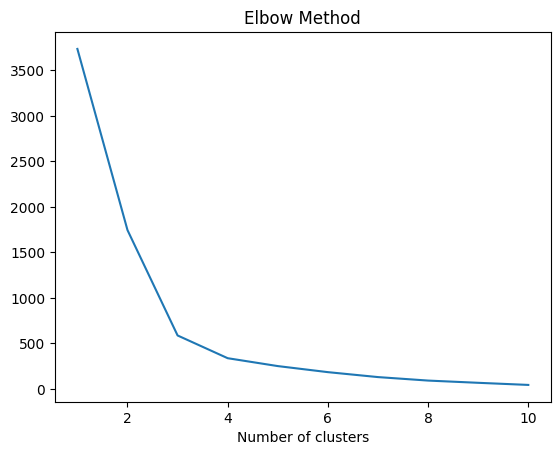

In [68]:
# Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(pca_data)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.show()

In [69]:
K = 3
kmeans = KMeans(n_clusters=K, init='k-means++', max_iter=300, n_init=10, random_state=0)
cluster_labels = kmeans.fit_predict(pca_data)

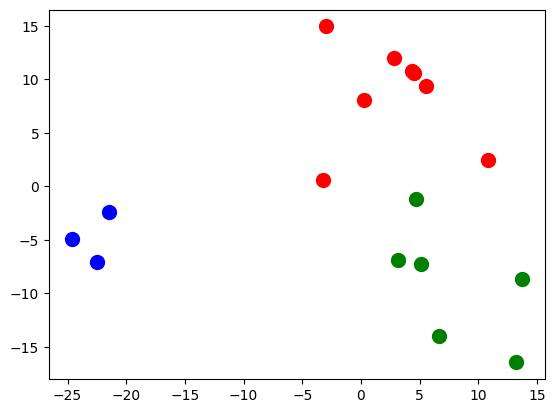

In [70]:
# Plotting the clusters
plt.scatter(pca_data[cluster_labels == 0, 0], pca_data[cluster_labels == 0, 1], s=100, c='red', label='Cluster 1')
plt.scatter(pca_data[cluster_labels == 1, 0], pca_data[cluster_labels == 1, 1], s=100, c='blue', label='Cluster 2')
plt.scatter(pca_data[cluster_labels == 2, 0], pca_data[cluster_labels == 2, 1], s=100, c='green', label='Cluster 3')
plt.show()

In [73]:
# Add the cluster labels to the dataframe
articles_original_df['CLUSTER'] = cluster_labels

In [79]:
articles_original_df[['CLUSTER', 'ARTICLE_TITLE']].sort_values(by='CLUSTER')

,CLUSTER,ARTICLE_TITLE
1,0,Genome Sequence of a Lethal Strain of Xylem-In...
3,0,Inference of the Molecular Mechanism of Action...
6,0,Data-Driven Revision of Decision Models
14,0,Orthogonal matrix factorization enables integr...
12,0,Gene network inference by fusing data from div...
13,0,Data Imputation in Epistatic MAPs by Network-G...
10,0,Gene network inference by probabilistic scorin...
9,0,Assessment of Machine Learning Reliability Met...
2,1,Educational Model for Promoting Creativity and...
8,1,The development of an entrepreneurial mindset ...


But we would in fact need to cluster co-authors, not articles. We will need to aggregate the articles by author.

In [76]:
# Aggregate articles by author
# Get the author's articles
author_articles_query = f"""
SELECT DISTINCT ARTICLE_SID,
                AUTHOR_SID
FROM PROD.FCT_COLLABORATION
WHERE ARTICLE_SID IN ({','.join([str(i) for i in articles_original_df['ARTICLE_SID']])})
"""

author_articles_df = bq_client.query(author_articles_query).to_dataframe()

In [78]:
author_articles_query = f"""
SELECT T.EMBEDDING_TENSOR_DATA
FROM PROD.FCT_ARTICLE F
    INNER JOIN PROD.DIM_ARTICLE A
        ON F.ARTICLE_SID = A.ARTICLE_SID
    INNER JOIN ANALYTICS.TEXT_EMBEDDING_ARTICLE_GECKO T
        ON A.ARTICLE_DOI = T.DOI
WHERE F.ARTICLE_SID IN ({','.join([str(i) for i in author_articles_df['ARTICLE_SID']])})
"""
author_articles_df = bq_client.query(author_articles_query).to_dataframe()

BadRequest: 400 Syntax error: Missing whitespace between literal and alias at [8:60]; reason: invalidQuery, location: query, message: Syntax error: Missing whitespace between literal and alias at [8:60]

Location: US
Job ID: a570f0e0-bb81-47ed-a3c2-3ca72929c10c
